In [22]:
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

In [23]:
traindf = pd.read_hdf("../data/traindf_clean.hdf")
testdf = pd.read_hdf("../data/test_clean.hdf")

In [24]:
print(list(traindf.columns))
print(list(testdf.columns))

['srch_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'std_avg_price_propid', 'std_avg_price_propid_after', 'amount_hotels', 'avg_price_propid_after', 'price_correction', 'avg_price_srchid', 'better_available_competitor', 'visited_before', 'price_quality', 'price_review', 'price_rank', 'total_loc_score', 'locationscore2_rank', 'locationscore1_rank', 'starrating_rank', 'price_diff_hist', 'diff_price_srchid', 'diff_price_propid', 'click_bool', 'booking_bool', 'position', 'importance']
['srch_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'std_avg_price_propid', 'std_avg_price_propid_after', 'amount_hotels', 'avg_price_propid_after', 'price_correction', 'avg_price_srchid', 'better_available_competitor', 'visited_before', 'price_quality', 'price_review', 'price_rank', 'total_loc_score', 'locationscore2_rank', 'locationscore1_rank', 'starrating_rank', 'price_diff_hist', 'diff_pr

In [25]:
traindf = traindf.sort_values(by=['srch_id'])

In [26]:
# split label and other variables
x_train, y_train = traindf, traindf["importance"]

# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, 
#                                                     test_size=0.99, 
#                                                     random_state=42, 
#                                                     shuffle=False, 
#                                                     stratify = None)


# Drop columns that are to be predicted with importance (which is set to y_train)
x_train = x_train.drop(columns=["position", "importance", "booking_bool", "click_bool"])

# x_test is the total testset with all columns. 
x_test = testdf

x_test = x_test.reindex(x_train.columns, axis=1)

In [27]:
# Check for correct shape and columns;
# x_train is probably much smaller because of downsampling: (50% of importance 5 and 1, 50% importance 0). 
# Number of columns in x_train and x_test must be equal!
print(x_train.shape, y_train.shape, x_test.shape)
print(list(x_train.columns))
print(list(x_test.columns))

(1383900, 24) (1383900,) (4959183, 24)
['srch_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'std_avg_price_propid', 'std_avg_price_propid_after', 'amount_hotels', 'avg_price_propid_after', 'price_correction', 'avg_price_srchid', 'better_available_competitor', 'visited_before', 'price_quality', 'price_review', 'price_rank', 'total_loc_score', 'locationscore2_rank', 'locationscore1_rank', 'starrating_rank', 'price_diff_hist', 'diff_price_srchid', 'diff_price_propid']
['srch_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'std_avg_price_propid', 'std_avg_price_propid_after', 'amount_hotels', 'avg_price_propid_after', 'price_correction', 'avg_price_srchid', 'better_available_competitor', 'visited_before', 'price_quality', 'price_review', 'price_rank', 'total_loc_score', 'locationscore2_rank', 'locationscore1_rank', 'starrating_rank', 'price_diff_hist', 'diff_price_srchid', 'dif

In [28]:
params = {'objective': 'rank:ndcg', 'learning_rate': 0.12,
          'max_depth': 6,  'n_estimators': 1000, 'silent':1}

# groups are equal to length of unique queries
query_lengths = x_train.groupby('srch_id').size().values

In [29]:
model = xgb.sklearn.XGBRanker(**params)
model.fit(x_train.drop(["prop_id", "srch_id", 'better_available_competitor', 'visited_before', 'prop_starrating', 'prop_review_score', 'std_avg_price_propid_after', 'prop_location_score1', 'price_correction'], axis=1), y_train, query_lengths, verbose=True)

XGBRanker(base_score=0.5, booster=None, colsample_bylevel=1, colsample_bynode=1,
          colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
          interaction_constraints=None, learning_rate=0.12, max_delta_step=0,
          max_depth=6, min_child_weight=1, missing=nan,
          monotone_constraints=None, n_estimators=1000, n_jobs=0,
          num_parallel_tree=1, objective='rank:ndcg', random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, silent=1,
          subsample=1, tree_method=None, validate_parameters=False,
          verbosity=None)

In [30]:
# Make fake column of positions to test score in ndcg scoring function,
# This is not needed for the testset, because there is nothing to check in the testset
# x_train["position_temp"] = x_train.groupby(['srch_id']).cumcount()+1

In [31]:
# x_train["position"] = y_train
predictions_sorted = []
prop_ids_sorted = []

# Sort predictions for each group SEPERATELY
for srchid, group in x_test.groupby('srch_id'):

    # Predictions for one search_id
    pred = model.predict(group.drop(["prop_id", "srch_id",'better_available_competitor', 'visited_before', 'prop_starrating', 'prop_review_score', 'std_avg_price_propid_after', 'prop_location_score1', 'price_correction'], axis=1))

    
    prop_id = [x for _,x in sorted(zip(pred, group.prop_id), reverse=True)]
    prop_ids_sorted.append(prop_id)
    
# Flatten lists
predictions_sorted = [item for sublist in predictions_sorted for item in sublist]
prop_ids_sorted = [item for sublist in prop_ids_sorted for item in sublist]


In [32]:
x_test["prop_id"] = prop_ids_sorted

In [33]:
x_test.head()

,srch_id,prop_id,prop_starrating,prop_review_score,prop_location_score1,prop_location_score2,std_avg_price_propid,std_avg_price_propid_after,amount_hotels,avg_price_propid_after,...,price_quality,price_review,price_rank,total_loc_score,locationscore2_rank,locationscore1_rank,starrating_rank,price_diff_hist,diff_price_srchid,diff_price_propid
0,1,99484,3,4.5,2.94,0.0691,11.710160,11.710160,185.0,125.520757,...,39.666667,26.444444,22.5,3.0091,10.0,25.5,18.5,113.97,-6.520757,25.203448
1,1,54937,3,4.5,2.64,0.0843,20.483788,20.483788,252.0,117.532579,...,39.333333,26.222222,21.0,2.7243,13.0,11.0,18.5,113.07,0.467421,24.203448
2,1,61934,2,3.5,2.71,0.0556,4.464016,4.464016,150.0,51.886600,...,NaN,14.000000,3.0,2.7656,6.0,12.0,5.0,44.84,-2.886600,-44.796552
3,1,28181,3,4.5,2.40,0.0561,27.965448,27.965448,147.0,133.987619,...,47.666667,31.777778,25.0,2.4561,7.0,8.0,18.5,137.97,9.012381,49.203448
4,1,95031,3,4.5,2.94,0.2090,14.807339,14.807339,214.0,86.308224,...,26.333333,17.555556,12.0,3.1490,22.5,25.5,18.5,74.28,-7.308224,-14.796552


## Test set only: convert to csv for submission

In [39]:
filename = "submission214mei.csv"
final_df = x_test[["srch_id", "prop_id"]]
final_df.to_csv(filename, columns=["srch_id", "prop_id"], index=False)

In [40]:
final_df.columns

Index(['srch_id', 'prop_id'], dtype='object')

In [41]:
# # Test if it worked
test = pd.read_csv(filename)
test.head()


,srch_id,prop_id
0,1,99484
1,1,54937
2,1,61934
3,1,28181
4,1,95031


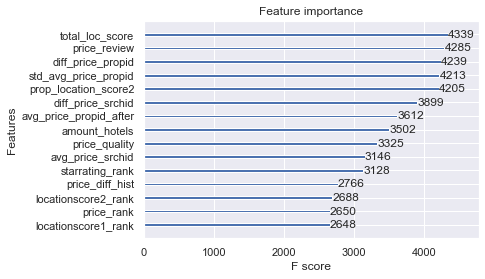

In [42]:
from sklearn.feature_selection import SelectFromModel
import matplotlib.pylab as plt
import seaborn as sns
sns.set()

xgb.plot_importance(booster=model )
plt.show()

In [38]:
'better_available_competitor', 'visited_before', 'prop_starrating', 'prop_review_score', 'std_avg_price_propid_after', 'prop_location_score1', 'price_correction'

('better_available_competitor',
 'visited_before',
 'prop_starrating',
 'prop_review_score',
 'std_avg_price_propid_after',
 'prop_location_score1',
 'price_correction')